# <font color="red">Icon Prediction with Stacking</font>

# Library Import

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Classification models
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import sys
sys.path.append('../../') # Uncomment this line if running locally
# sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
# weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggle
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

,DateTime,Year,Month,Day,Hour,DaySegments,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,...,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy,Conditions,Icon
0,2023-01-01 00:00:00,2023,1,1,0,Late Night,0,0,0,1,...,0.49,1018.68,0.03,0.0,10.0,2.76,0.0,0.0,Clear,clear-night
1,2023-01-01 01:00:00,2023,1,1,1,Late Night,0,0,0,1,...,0.54,1018.03,0.11,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
2,2023-01-01 02:00:00,2023,1,1,2,Late Night,0,0,0,1,...,30.51,1017.56,0.03,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
3,2023-01-01 03:00:00,2023,1,1,3,Late Night,0,0,0,1,...,49.23,1018.05,0.00,0.0,10.0,2.28,0.0,0.0,Clear,clear-night
4,2023-01-01 04:00:00,2023,1,1,4,Late Night,0,0,0,1,...,49.90,1018.00,86.17,0.0,10.0,1.27,0.0,0.0,Partially cloudy,fog


In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

,DateTime,Year,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,DaySegments_Midday,...,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy
count,14616,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,...,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000
mean,2023-11-01 11:30:00,2023.400657,5.720854,15.735632,11.500000,0.131294,0.060550,0.098043,0.249726,0.116585,...,17.068560,8.090783,159.739178,1008.265012,53.579923,2.263555,16.504787,4.368134,227.640683,0.819217
min,2023-01-01 00:00:00,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.000000,0.000000,982.420000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,2023-06-02 05:45:00,2023.000000,3.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.170000,2.870000,80.965000,1003.277500,26.670000,0.000000,10.000000,3.990000,0.000000,0.000000
50%,2023-11-01 11:30:00,2023.000000,6.000000,16.000000,11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.645000,7.670000,163.790000,1007.970000,51.540000,0.000000,10.000000,4.650000,10.665000,0.010000
75%,2024-04-01 17:15:00,2024.000000,8.000000,23.000000,17.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.410000,11.750000,241.402500,1013.400000,87.790000,4.740000,12.580000,4.650000,459.745000,1.660000
max,2024-08-31 23:00:00,2024.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,84.120000,71.970000,360.000000,1022.060000,100.000000,10.000000,97.740000,24.100000,1026.650000,3.700000
std,NaN,0.490048,3.195073,8.803610,6.922423,0.337734,0.238511,0.297383,0.432869,0.320936,...,10.195911,6.250203,104.422027,6.010683,35.166637,3.083074,15.031827,1.376994,307.219387,1.106444


# Data Split

In [5]:
# Remove classes with only 1 sample to satisfy StratifiedShuffleSplit requirements
icon_counts = weather_data['Icon'].value_counts()
valid_icons = icon_counts[icon_counts > 1].index
weather_data_filtered = weather_data[weather_data['Icon'].isin(valid_icons)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data_filtered, weather_data_filtered['Icon']):
    weather_data_train = weather_data_filtered.iloc[train_idx]
    weather_data_test = weather_data_filtered.iloc[test_idx]

In [6]:
# Show the count of each unique class in Icon
class_counts = weather_data['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20
7                 wind      1


In [7]:
# Show the count of each unique class in Icon
class_counts = weather_data_filtered['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20


In [8]:
print("Distribution of Icon in Training Set:")
print(weather_data_train['Icon'].value_counts())

print("\nDistribution of Icon in Test Set:")
print(weather_data_test['Icon'].value_counts())

Distribution of Icon in Training Set:
Icon
partly-cloudy-night    3121
partly-cloudy-day      3095
rain                   2309
clear-night            1449
clear-day              1204
cloudy                  498
fog                      16
Name: count, dtype: int64

Distribution of Icon in Test Set:
Icon
partly-cloudy-night    780
partly-cloudy-day      774
rain                   577
clear-night            362
clear-day              301
cloudy                 125
fog                      4
Name: count, dtype: int64


# Some Reused Variables

In [9]:
model_name_for_saving = "Stack"
target_name_for_saving = "Icon"

# MinMax Scaler

## Best Features

In [10]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Icon']

In [11]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Icon']

In [12]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [13]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


## Scaler

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [15]:
X_train

array([[0.45454545, 0.04347826, 0.        , ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.82608696, 0.        , ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.13043478, 0.        , ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.47826087, 0.        , ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.39130435, 0.        , ..., 0.9903    , 0.471     ,
        0.07388643]], shape=(11692, 23))

In [16]:
X_test

array([[0.81818182, 0.04347826, 0.        , ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.13043478, 0.        , ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.65217391, 1.        , ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13043478, 0.        , ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.60869565, 1.        , ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.47826087, 0.        , ..., 1.        , 0.119     ,
        0.07388643]], shape=(2923, 23))

## Model with Best Parameters

In [17]:
# Define base classifiers for stacking
base_classifiers = [
    ('DecisionTree', DecisionTreeClassifier(random_state=42)),

    ('GradientBoosting', GradientBoostingClassifier(validation_fraction=0.2,
                                                    subsample=0.8,
                                                    n_iter_no_change=15,
                                                    n_estimators=300,
                                                    min_samples_split=5,
                                                    min_samples_leaf=8,
                                                    min_impurity_decrease=0.0,
                                                    max_features=None,
                                                    max_depth=11,
                                                    loss='log_loss',
                                                    learning_rate=0.01,
                                                    ccp_alpha=0.0)),

    ('LightGBM', LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')),

    ('RandomForest', RandomForestClassifier(n_estimators=100,
                                            min_samples_split=5,
                                            min_samples_leaf=1,
                                            min_impurity_decrease=0.0,
                                            max_samples=0.8,
                                            max_features=None,
                                            max_depth=None,
                                            bootstrap=True)),

    ('SVM', SVC(tol=0.0001,
                shrinking=True,
                kernel='linear',
                gamma='scale',
                coef0=0.1,
                class_weight=None,
                C=100,
                probability=True)),

    ('LogisticRegression', LogisticRegression(C=100.0,
                                              max_iter=3000,
                                              penalty='l1',
                                              solver='saga')),

    ('AdaBoost', AdaBoostClassifier(n_estimators=200,
                                    learning_rate=1.0)),

    ('KNN', BaggingClassifier(estimator=KNeighborsClassifier(),
                              n_estimators=100,
                              random_state=42,
                              verbose=1,
                              n_jobs=-1,
                              bootstrap_features=True,
                              max_features=0.8))
]

# Define meta-classifier (final estimator)
meta_classifier = LogisticRegression(random_state=42, max_iter=10000)

In [18]:
# Create Stacking Classifier
training_model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5,  # Cross-validation folds for training base classifiers
    stack_method='predict_proba',  # Use probabilities for stacking
    n_jobs=-1,
    verbose=1
)

training_model

,estimators,"[('DecisionTree', ...), ('GradientBoosting', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2


## Training

In [19]:
%%time
print("Training Stacking Classifier with base models:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__}")
print(f"Meta-classifier: {type(meta_classifier).__name__}")
print()

training_model.fit(X_train, y_train)

Training Stacking Classifier with base models:
  - DecisionTree: DecisionTreeClassifier
  - GradientBoosting: GradientBoostingClassifier
  - LightGBM: LGBMClassifier
  - RandomForest: RandomForestClassifier
  - SVM: SVC
  - LogisticRegression: LogisticRegression
  - AdaBoost: AdaBoostClassifier
  - KNN: BaggingClassifier
Meta-classifier: LogisticRegression

CPU times: total: 2.22 s
Wall time: 7min 9s


,estimators,"[('DecisionTree', ...), ('GradientBoosting', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2


In [20]:
y_pred = training_model.predict(X_test)
y_pred

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   13.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype=object)

In [21]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [22]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [23]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9935
Precision: 0.9922
Recall:    0.9935
F1-Score:  0.9928


In [24]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



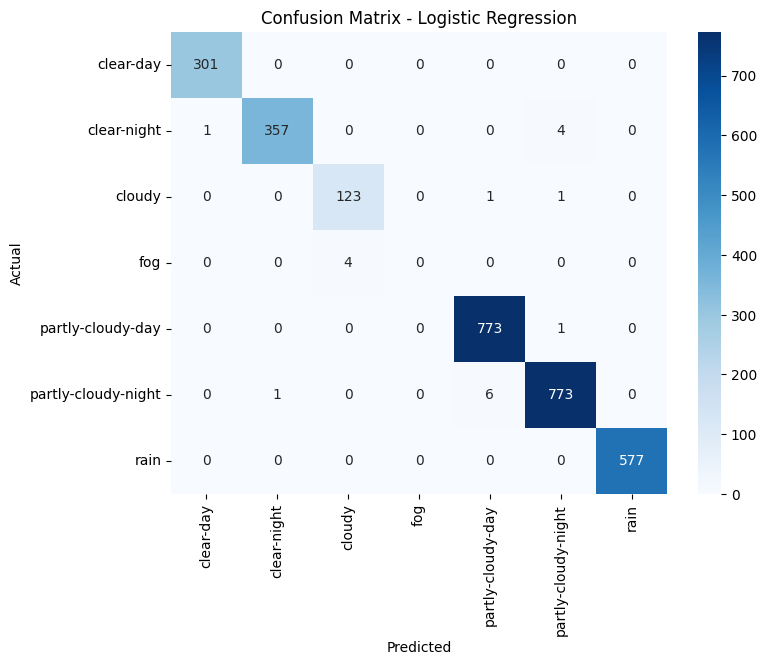

In [25]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.2s remaining:   12.9s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.6s finished


In [27]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9975
fog      : 0.8357
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9999
rain     : 1.0000
Micro-avg : 0.9995


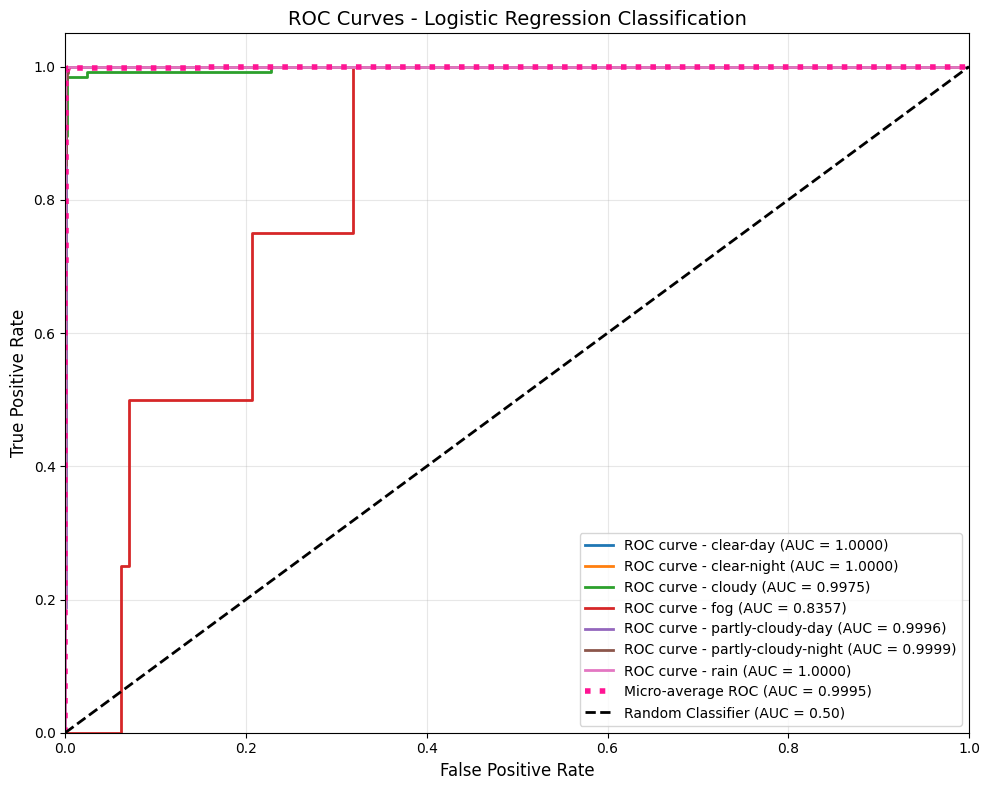

In [29]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9995
One-vs-One (Weighted)  : 0.9846
Micro-average          : 0.9995


In [31]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

# Convert parameters to JSON-serializable format
def make_json_serializable(params):
    """Convert complex objects to JSON-serializable strings"""
    serializable_params = {}
    for key, value in params.items():
        if hasattr(value, '__class__') and hasattr(value, 'get_params'):
            # For sklearn objects, store class name and parameters
            serializable_params[key] = {
                'class_name': value.__class__.__name__,
                'module': value.__class__.__module__,
                'params': str(value.get_params())
            }
        elif callable(value):
            # For functions, store string representation
            serializable_params[key] = str(value)
        elif isinstance(value, (list, tuple)) and len(value) > 0 and hasattr(value[0], '__class__'):
            # For lists of sklearn objects (like estimators in StackingClassifier)
            serializable_params[key] = [
                {
                    'name': item[0] if isinstance(item, tuple) else str(item),
                    'class_name': item[1].__class__.__name__ if isinstance(item, tuple) else item.__class__.__name__,
                    'params': str(item[1].get_params()) if isinstance(item, tuple) else str(item.get_params())
                } for item in value
            ]
        else:
            # For primitive types, keep as is
            serializable_params[key] = value
    return serializable_params

# Get serializable parameters
model_params = make_json_serializable(training_model.get_params())

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(model_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.993500, F1: 0.992822, AUC (micro-avg): 0.999456
   Features: 23
💾 Registry updated: Model_Training_History/History_Classification.csv


# Standard Scaler

## Best Features

In [32]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Icon']

In [33]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Icon']

In [34]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [35]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


## Scaler

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [37]:
X_train

array([[ 0.08873237, -1.51753864, -0.3888967 , ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.07523376, -0.3888967 , ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.21927667, -0.3888967 , ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591, -1.22945281, -0.3888967 , ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.07710953, -0.3888967 , ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -0.36519535, -0.3888967 , ...,  1.29498106,
         0.80247092, -0.4299225 ]], shape=(11692, 23))

In [38]:
X_test

array([[ 1.33830651, -1.51753864, -0.3888967 , ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -1.22945281, -0.3888967 , ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.49906212,  2.5713769 , ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22945281, -0.3888967 , ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004,  0.35501921,  2.5713769 , ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.07710953, -0.3888967 , ...,  1.32256164,
        -0.34325307, -0.4299225 ]], shape=(2923, 23))

## Model with Best Parameters

In [39]:
# Define base classifiers for stacking
base_classifiers = [
    ('DecisionTree', DecisionTreeClassifier(random_state=42)),

    ('GradientBoosting', GradientBoostingClassifier(validation_fraction=0.2,
                                                    subsample=0.8,
                                                    n_iter_no_change=15,
                                                    n_estimators=300,
                                                    min_samples_split=5,
                                                    min_samples_leaf=8,
                                                    min_impurity_decrease=0.0,
                                                    max_features=None,
                                                    max_depth=11,
                                                    loss='log_loss',
                                                    learning_rate=0.01,
                                                    ccp_alpha=0.0)),

    ('LightGBM', LGBMClassifier(subsample_for_bin=500000,
                                reg_lambda=0.1,
                                reg_alpha=1.0,
                                num_leaves=50,
                                n_estimators=300,
                                min_split_gain=0.0,
                                min_child_weight=0.01,
                                min_child_samples=200,
                                max_depth=5,
                                learning_rate=0.1,
                                feature_fraction=0.9,
                                bagging_freq=0,
                                bagging_fraction=0.9)),

    ('RandomForest', RandomForestClassifier(n_estimators=100,
                                            min_samples_split=5,
                                            min_samples_leaf=1,
                                            min_impurity_decrease=0.0,
                                            max_samples=0.8,
                                            max_features=None,
                                            max_depth=None,
                                            bootstrap=True)),

    ('SVM', SVC(tol=0.0001,
                shrinking=True,
                kernel='linear',
                gamma='scale',
                coef0=0.1,
                class_weight=None,
                C=100,
                probability=True)),

    ('LogisticRegression', LogisticRegression(C=100.0,
                                              max_iter=2000,
                                              penalty='l1',
                                              solver='liblinear')),

    ('AdaBoost', AdaBoostClassifier(n_estimators=200,
                                    learning_rate=1.0)),

    ('KNN', BaggingClassifier(estimator=KNeighborsClassifier(),
                              n_estimators=100,
                              random_state=42,
                              verbose=1,
                              n_jobs=-1,
                              bootstrap_features=True,
                              max_features=0.8))
]

# Define meta-classifier (final estimator)
meta_classifier = LogisticRegression(random_state=42, max_iter=10000)

In [40]:
# Create Stacking Classifier
training_model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5,  # Cross-validation folds for training base classifiers
    stack_method='predict_proba',  # Use probabilities for stacking
    n_jobs=-1,
    verbose=1
)

training_model

,estimators,"[('DecisionTree', ...), ('GradientBoosting', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2


## Training

In [41]:
%%time
print("Training Stacking Classifier with base models:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__}")
print(f"Meta-classifier: {type(meta_classifier).__name__}")
print()

training_model.fit(X_train, y_train)

Training Stacking Classifier with base models:
  - DecisionTree: DecisionTreeClassifier
  - GradientBoosting: GradientBoostingClassifier
  - LightGBM: LGBMClassifier
  - RandomForest: RandomForestClassifier
  - SVM: SVC
  - LogisticRegression: LogisticRegression
  - AdaBoost: AdaBoostClassifier
  - KNN: BaggingClassifier
Meta-classifier: LogisticRegression

CPU times: total: 2.33 s
Wall time: 9min 6s


,estimators,"[('DecisionTree', ...), ('GradientBoosting', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2


In [42]:
y_pred = training_model.predict(X_test)
y_pred

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.2s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype=object)

In [43]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [44]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [45]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9942
Precision: 0.9928
Recall:    0.9942
F1-Score:  0.9935


In [46]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      1.00       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



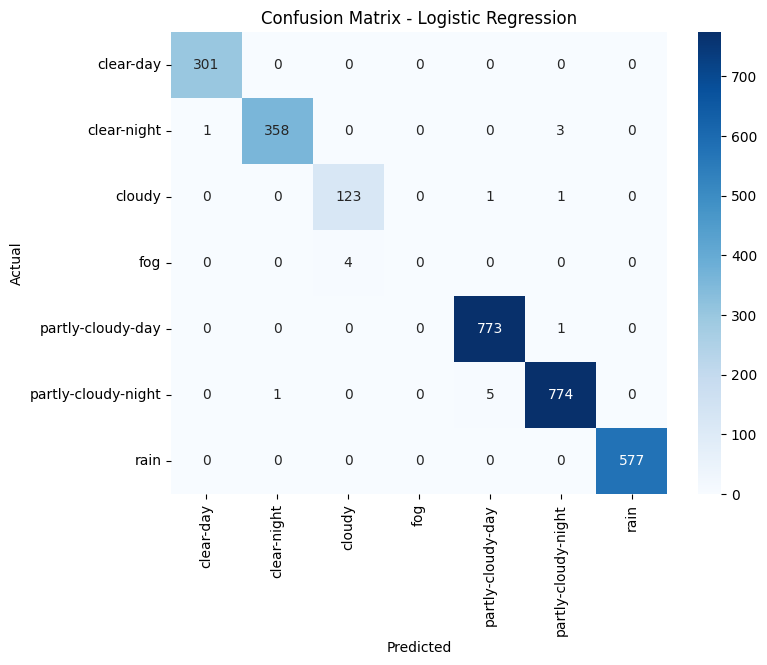

In [47]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.0s remaining:   12.3s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished


In [49]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [50]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9955
fog      : 0.8860
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9998
rain     : 1.0000
Micro-avg : 0.9995


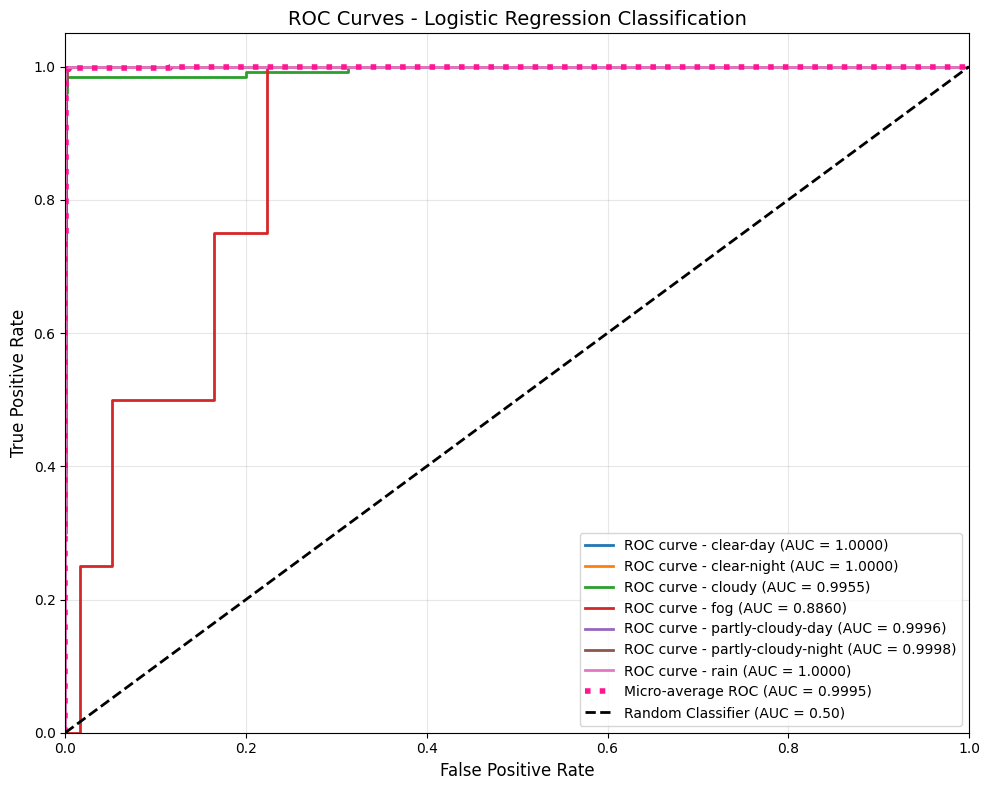

In [51]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9995
One-vs-One (Weighted)  : 0.9887
Micro-average          : 0.9995


In [53]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

# Convert parameters to JSON-serializable format
def make_json_serializable(params):
    """Convert complex objects to JSON-serializable strings"""
    serializable_params = {}
    for key, value in params.items():
        if hasattr(value, '__class__') and hasattr(value, 'get_params'):
            # For sklearn objects, store class name and parameters
            serializable_params[key] = {
                'class_name': value.__class__.__name__,
                'module': value.__class__.__module__,
                'params': str(value.get_params())
            }
        elif callable(value):
            # For functions, store string representation
            serializable_params[key] = str(value)
        elif isinstance(value, (list, tuple)) and len(value) > 0 and hasattr(value[0], '__class__'):
            # For lists of sklearn objects (like estimators in StackingClassifier)
            serializable_params[key] = [
                {
                    'name': item[0] if isinstance(item, tuple) else str(item),
                    'class_name': item[1].__class__.__name__ if isinstance(item, tuple) else item.__class__.__name__,
                    'params': str(item[1].get_params()) if isinstance(item, tuple) else str(item.get_params())
                } for item in value
            ]
        else:
            # For primitive types, keep as is
            serializable_params[key] = value
    return serializable_params

# Get serializable parameters
model_params = make_json_serializable(training_model.get_params())

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(model_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.994184, F1: 0.993507, AUC (micro-avg): 0.999494
   Features: 23
💾 Registry updated: Model_Training_History/History_Classification.csv


# Robust Scaler

## Best Features

In [54]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Icon']

In [55]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Icon']

In [56]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [57]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


## Scaler

In [58]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [59]:
X_train

array([[ 0.00000000e+00, -9.16666667e-01,  0.00000000e+00, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  5.83333333e-01,  0.00000000e+00, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01, -7.50000000e-01,  0.00000000e+00, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.33333333e-02,  0.00000000e+00, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -2.50000000e-01,  0.00000000e+00, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]],
      shape=(11692, 23))

In [60]:
X_test

array([[ 0.8       , -0.91666667,  0.        , ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.75      ,  0.        , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.25      ,  1.        , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.75      ,  0.        , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        ,  0.16666667,  1.        , ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.08333333,  0.        , ...,  0.79384817,
         0.25757576,  0.        ]], shape=(2923, 23))

## Model with Best Parameters

In [61]:
# Define base classifiers for stacking
base_classifiers = [
    ('DecisionTree', DecisionTreeClassifier(random_state=42)),

    ('GradientBoosting', GradientBoostingClassifier(validation_fraction=0.2,
                                                    subsample=0.8,
                                                    n_iter_no_change=15,
                                                    n_estimators=300,
                                                    min_samples_split=5,
                                                    min_samples_leaf=8,
                                                    min_impurity_decrease=0.0,
                                                    max_features=None,
                                                    max_depth=11,
                                                    loss='log_loss',
                                                    learning_rate=0.01,
                                                    ccp_alpha=0.0)),

    ('LightGBM', LGBMClassifier(subsample_for_bin=200000,
                                reg_lambda=0.5,
                                reg_alpha=1.0,
                                num_leaves=31,
                                n_estimators=300,
                                min_split_gain=0.0,
                                min_child_weight=0.01,
                                min_child_samples=50,
                                max_depth=3,
                                learning_rate=0.05,
                                feature_fraction=1.0,
                                bagging_freq=0,
                                bagging_fraction=0.8)),

    ('RandomForest', RandomForestClassifier(n_estimators=100,
                                            min_samples_split=5,
                                            min_samples_leaf=1,
                                            min_impurity_decrease=0.0,
                                            max_samples=0.8,
                                            max_features=None,
                                            max_depth=None,
                                            bootstrap=True)),

    ('SVM', SVC(C=100,
                class_weight=None,
                coef0=0.1,
                gamma='scale',
                kernel='linear',
                shrinking=True,
                tol=0.0001,
                probability=True)),

    ('LogisticRegression', LogisticRegression(C=100.0,
                                              max_iter=2000,
                                              penalty='l1',
                                              solver='liblinear')),

    ('AdaBoost', AdaBoostClassifier(n_estimators=200,
                                    learning_rate=1.0)),

    ('KNN', BaggingClassifier(estimator=KNeighborsClassifier(),
                              n_estimators=100,
                              random_state=42,
                              verbose=1,
                              n_jobs=-1,
                              bootstrap_features=True,
                              max_features=0.8))
]

# Define meta-classifier (final estimator)
meta_classifier = LogisticRegression(random_state=42, max_iter=10000)

In [62]:
# Create Stacking Classifier
training_model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5,  # Cross-validation folds for training base classifiers
    stack_method='predict_proba',  # Use probabilities for stacking
    n_jobs=-1,
    verbose=1
)

training_model

,estimators,"[('DecisionTree', ...), ('GradientBoosting', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2


## Training

In [63]:
%%time
print("Training Stacking Classifier with base models:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__}")
print(f"Meta-classifier: {type(meta_classifier).__name__}")
print()

training_model.fit(X_train, y_train)

Training Stacking Classifier with base models:
  - DecisionTree: DecisionTreeClassifier
  - GradientBoosting: GradientBoostingClassifier
  - LightGBM: LGBMClassifier
  - RandomForest: RandomForestClassifier
  - SVM: SVC
  - LogisticRegression: LogisticRegression
  - AdaBoost: AdaBoostClassifier
  - KNN: BaggingClassifier
Meta-classifier: LogisticRegression

CPU times: total: 2.94 s
Wall time: 14min 55s


,estimators,"[('DecisionTree', ...), ('GradientBoosting', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2


In [64]:
y_pred = training_model.predict(X_test)
y_pred

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.2s remaining:   12.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.9s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype=object)

In [65]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [66]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [67]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9945
Precision: 0.9932
Recall:    0.9945
F1-Score:  0.9939


In [68]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      1.00       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



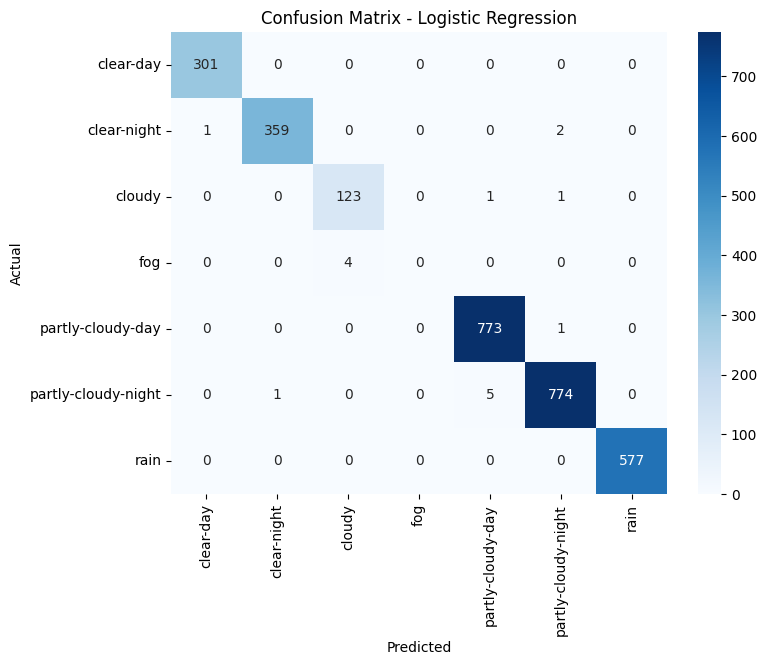

In [69]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [70]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   13.2s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.7s finished


In [71]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [72]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9953
fog      : 0.8209
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9999
rain     : 1.0000
Micro-avg : 0.9994


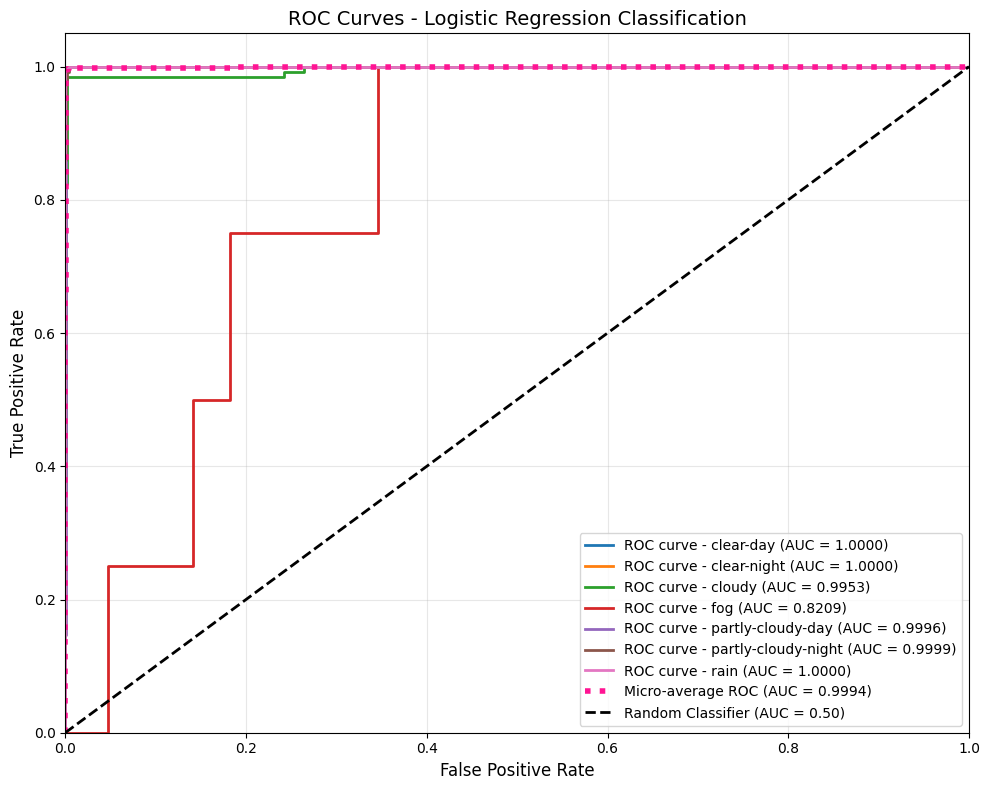

In [73]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [74]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9827
Micro-average          : 0.9994


In [75]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

# Convert parameters to JSON-serializable format
def make_json_serializable(params):
    """Convert complex objects to JSON-serializable strings"""
    serializable_params = {}
    for key, value in params.items():
        if hasattr(value, '__class__') and hasattr(value, 'get_params'):
            # For sklearn objects, store class name and parameters
            serializable_params[key] = {
                'class_name': value.__class__.__name__,
                'module': value.__class__.__module__,
                'params': str(value.get_params())
            }
        elif callable(value):
            # For functions, store string representation
            serializable_params[key] = str(value)
        elif isinstance(value, (list, tuple)) and len(value) > 0 and hasattr(value[0], '__class__'):
            # For lists of sklearn objects (like estimators in StackingClassifier)
            serializable_params[key] = [
                {
                    'name': item[0] if isinstance(item, tuple) else str(item),
                    'class_name': item[1].__class__.__name__ if isinstance(item, tuple) else item.__class__.__name__,
                    'params': str(item[1].get_params()) if isinstance(item, tuple) else str(item.get_params())
                } for item in value
            ]
        else:
            # For primitive types, keep as is
            serializable_params[key] = value
    return serializable_params

# Get serializable parameters
model_params = make_json_serializable(training_model.get_params())

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(model_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.994526, F1: 0.993850, AUC (micro-avg): 0.999409
   Features: 23
💾 Registry updated: Model_Training_History/History_Classification.csv


# All Performance

In [76]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
Model         Scaler Target  Features Accuracy Precision   Recall F1-Score
Stack   RobustScaler   Icon        23 0.994526  0.993188 0.994526 0.993850
Stack StandardScaler   Icon        23 0.994184  0.992846 0.994184 0.993507
Stack   MinMaxScaler   Icon        23 0.993500  0.992166 0.993500 0.992822

📈 Total models shown: 3
🏆 Best F1-Score: 0.993850 (Stack + RobustScaler for Icon)


# <center><font size="50" color="red">Thank You</font></center>